# Equity in post-HCT Survival Predictions


In [ ]:
# Install required packages
!pip install -q kaggle lifelines tab-transformer-pytorch torch tqdm scikit-plot

# Import libraries
import pandas as pd
import numpy as np
import torch
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tab_transformer_pytorch import FTTransformer
import json
import os
from google.colab import files
import joblib
from tabulate import tabulate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.3 MB/s eta 0:00:00


# Kaggle API setup

In [ ]:

os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_cred = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_cred, f)
!chmod 600 /root/.kaggle/kaggle.json

# Download data
!kaggle competitions download -c equity-post-hct-survival-predictions
!unzip -q equity-post-hct-survival-predictions.zip

# Security cleanup
!rm -rf /root/.kaggle/kaggle.json

# Load data with validation

In [ ]:

try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print("✅ Data loaded successfully!")

    # Verify columns
    required_cols = ['ID', 'efs', 'efs_time', 'race_group']
    assert all(col in train_df.columns for col in required_cols)
    assert 'ID' in test_df.columns

    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

✅ Data loaded successfully!
Training samples: 28800
Test samples: 3


In [ ]:
print('It has',train_df.shape[0],'rows and ',train_df.shape[1],'columns' )


It has 28800 rows and  60 columns


In [ ]:
train_df.head()


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [ ]:
train_df.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [ ]:
train_df.isnull().values.any()

np.True_

In [ ]:
train_df.isnull().sum()

,0
ID,0
dri_score,154
psych_disturb,2062
cyto_score,8068
diabetes,2119
hla_match_c_high,4620
hla_high_res_8,5829
tbi_status,0
arrhythmia,2202
hla_low_res_6,3270


## Missing percentage of Null values

In [ ]:
missing_count = train_df.isnull().sum()
missing_percentage = (missing_count / len(train_df)) * 100
print(missing_percentage)

ID                         0.000000
dri_score                  0.534722
psych_disturb              7.159722
cyto_score                28.013889
diabetes                   7.357639
hla_match_c_high          16.041667
hla_high_res_8            20.239583
tbi_status                 0.000000
arrhythmia                 7.645833
hla_low_res_6             11.354167
graft_type                 0.000000
vent_hist                  0.899306
renal_issue                6.649306
pulm_severe                7.413194
prim_disease_hct           0.000000
hla_high_res_6            18.347222
cmv_status                 2.201389
hla_high_res_10           24.871528
hla_match_dqb1_high       18.052083
tce_imm_match             38.656250
hla_nmdp_6                14.572917
hla_match_c_low            9.722222
rituximab                  7.458333
hla_match_drb1_low         9.177083
hla_match_dqb1_low        14.562500
prod_type                  0.000000
cyto_score_detail         41.399306
conditioning_intensity    16

# ==================== INITIAL DATA VISUALIZATION ====================


BEGINNING DATA EXPLORATION VISUALIZATIONS


VISUALIZATION 1: EVENT TIME DISTRIBUTION
• Shows how long patients were followed until an event occurred
• Red dashed line indicates median survival time
• Green shaded area represents censored patients (no event)
• Red shaded area represents patients who experienced the event
• Right-skewed distribution suggests most events happen earlier
• Check for unexpected gaps or clusters in event times



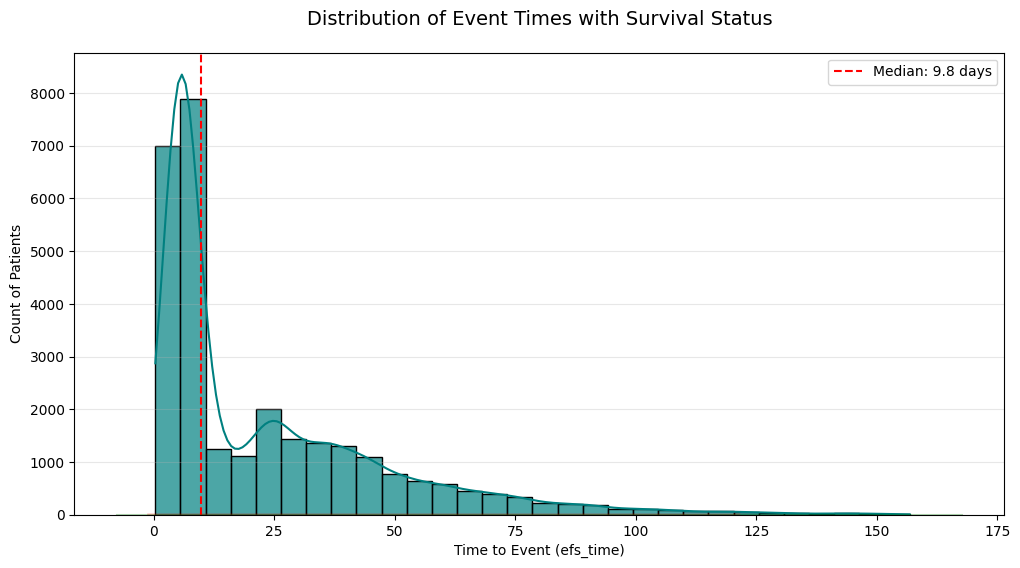


--------------------------------------------------------------------------------


VISUALIZATION 2: OVERALL EVENT OCCURRENCE
• Shows proportion of patients who experienced the event (1) vs censored (0)
• Healthy datasets typically have 40-60% events (varies by study)
• Significant imbalance may require special handling



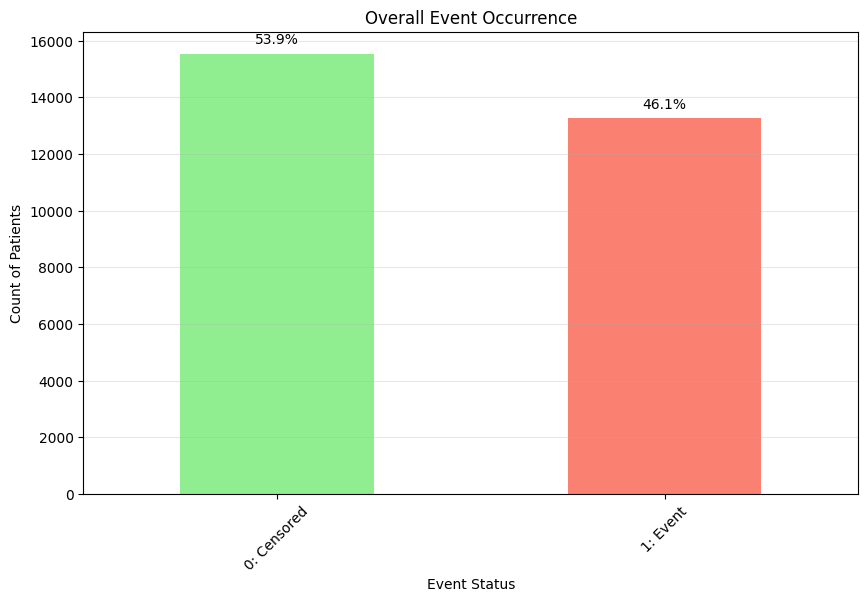


--------------------------------------------------------------------------------


    VISUALIZATION 3: EVENT STATUS BY RACE GROUP
    • Shows event distribution across racial groups (if available)
    • Helps identify potential disparities in outcomes
    • Check if certain groups have higher event rates
    


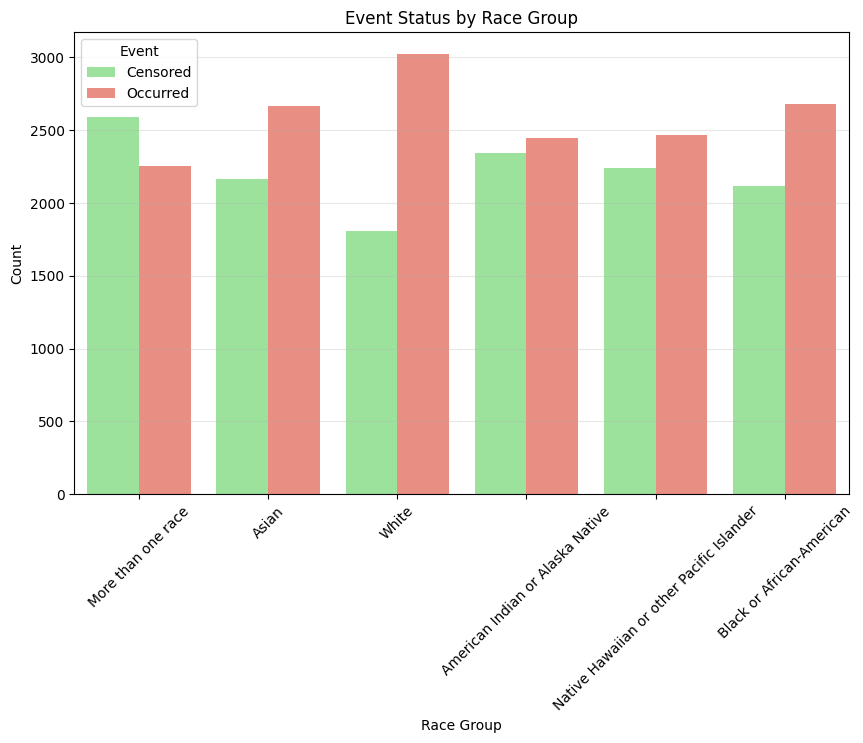


--------------------------------------------------------------------------------


VISUALIZATION 4: NUMERICAL FEATURE CORRELATIONS
• Shows correlations between numerical features
• Red: Strong positive correlation
• Blue: Strong negative correlation
• Look for highly correlated features (>0.8 or <-0.8) that might need handling



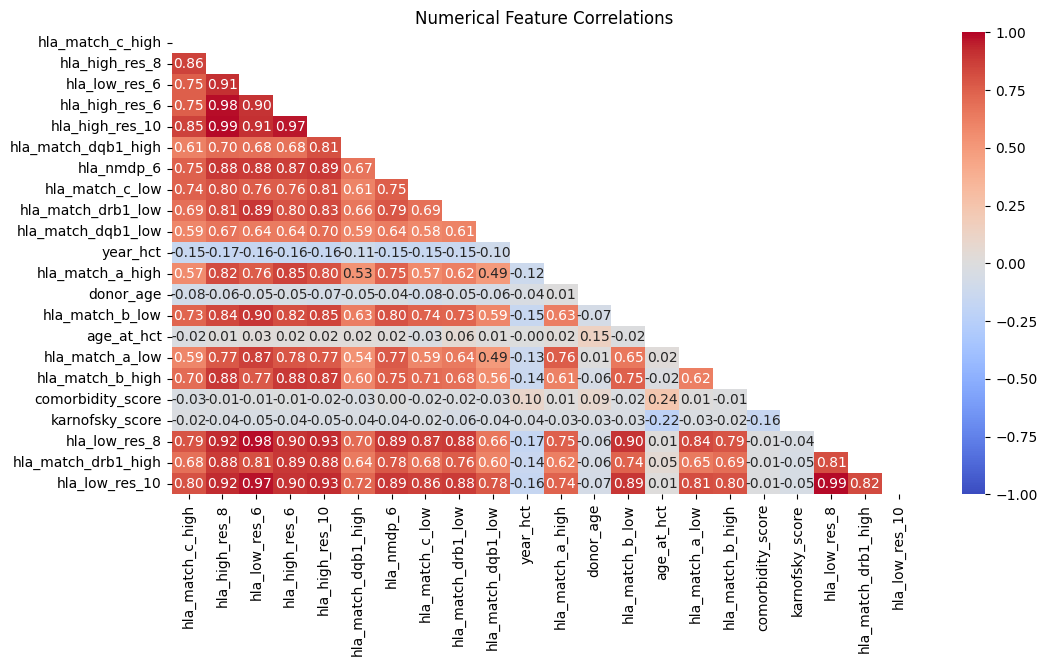


--------------------------------------------------------------------------------



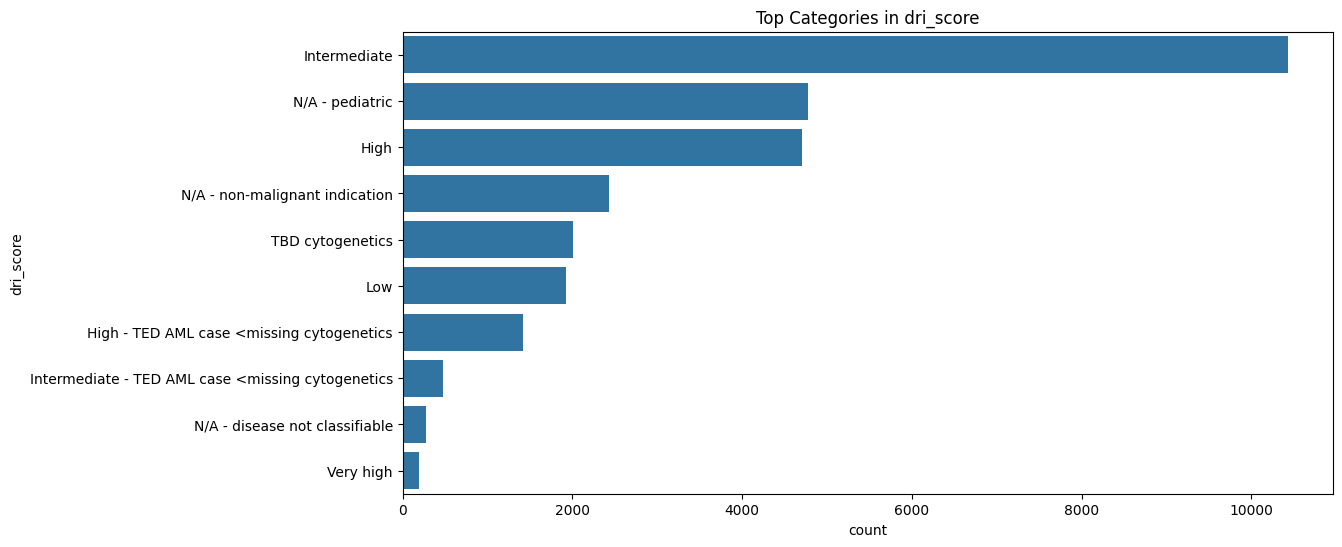


        VISUALIZATION 5: TOP CATEGORIES IN dri_score
        • Shows distribution of categories for one selected categorical feature
        • Helps identify dominant categories and rare ones
        • Check for categories with very few samples that might need grouping
        

--------------------------------------------------------------------------------



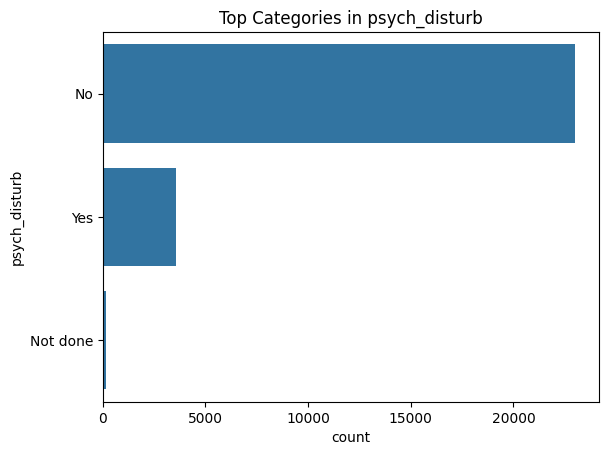


        VISUALIZATION 5: TOP CATEGORIES IN psych_disturb
        • Shows distribution of categories for one selected categorical feature
        • Helps identify dominant categories and rare ones
        • Check for categories with very few samples that might need grouping
        

--------------------------------------------------------------------------------



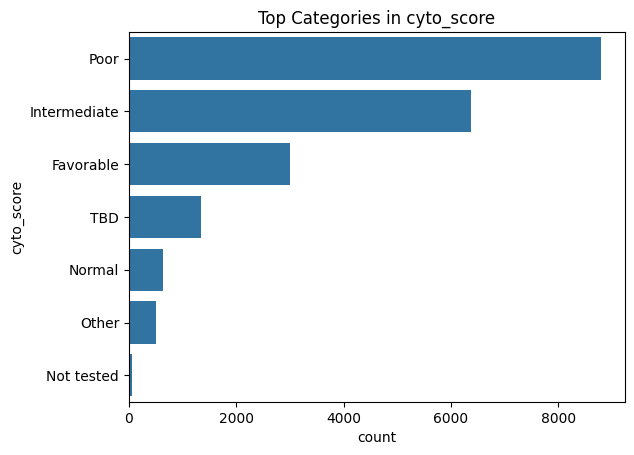


        VISUALIZATION 5: TOP CATEGORIES IN cyto_score
        • Shows distribution of categories for one selected categorical feature
        • Helps identify dominant categories and rare ones
        • Check for categories with very few samples that might need grouping
        

--------------------------------------------------------------------------------


VISUALIZATION 6: MISSING VALUES MAP
• Yellow lines indicate missing values
• Vertical stripes: Features with missing values
• Horizontal stripes: Patients with missing data
• Check for patterns in missingness



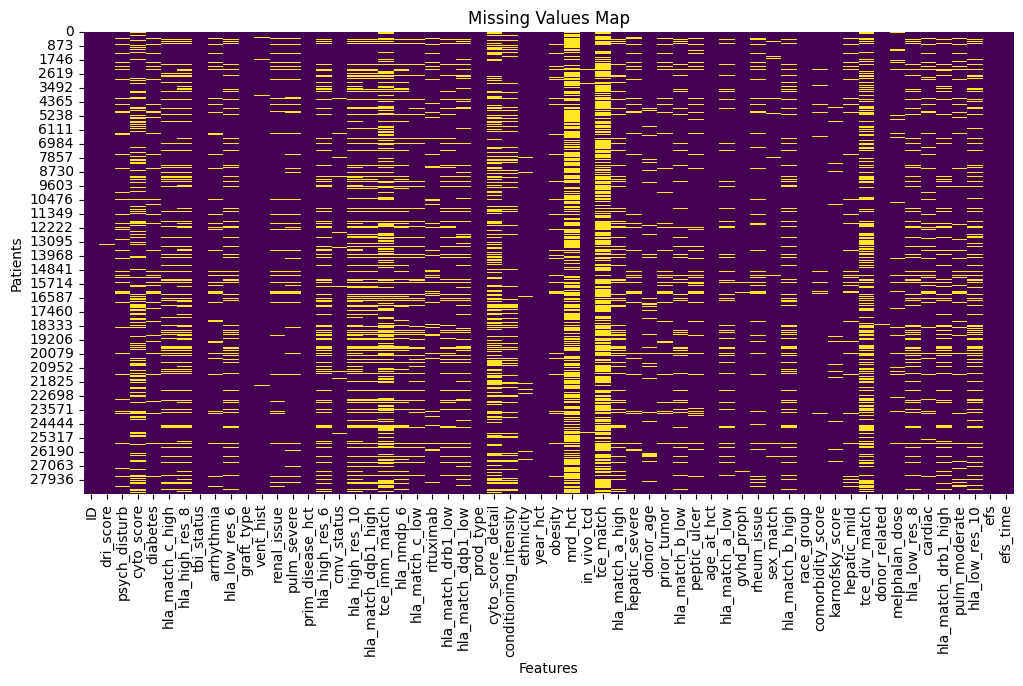


--------------------------------------------------------------------------------


VISUALIZATION 7: PERCENTAGE OF MISSING VALUES PER FEATURE
• Shows percentage of missing values per feature
• Red dashed line at 30% threshold
• Features above this line may need special handling
• Consider whether missingness is random or systematic



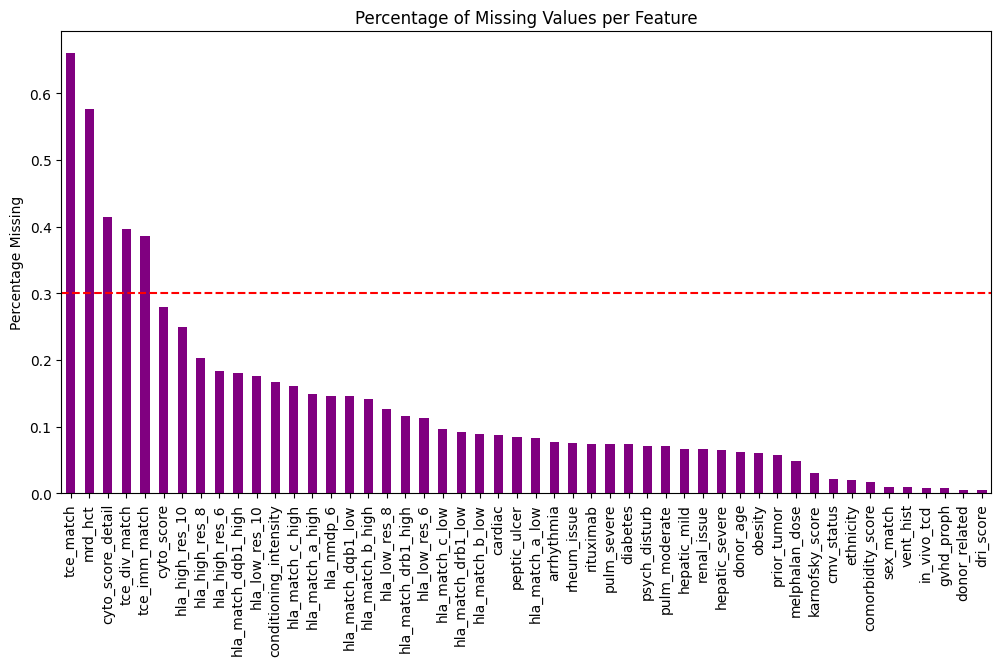


DATA EXPLORATION COMPLETE - PROCEEDING TO PREPROCESSING



In [ ]:


print("\n" + "="*60)
print("BEGINNING DATA EXPLORATION VISUALIZATIONS")
print("="*60 + "\n")

# 1. Event Time Distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_df['efs_time'], bins=30, kde=True, color='teal', alpha=0.7)
plt.title('Distribution of Event Times with Survival Status', fontsize=14, pad=20)
plt.xlabel('Time to Event (efs_time)')
plt.ylabel('Count of Patients')

# Add vertical line at median
median_time = train_df['efs_time'].median()
plt.axvline(median_time, color='red', linestyle='--',
            label=f'Median: {median_time:.1f} days')

# Add survival status overlay
sns.kdeplot(data=train_df, x='efs_time', hue='efs',
           palette={0:'green', 1:'red'}, alpha=0.3)

plt.grid(axis='y', alpha=0.3)
plt.legend()

print("""
VISUALIZATION 1: EVENT TIME DISTRIBUTION
• Shows how long patients were followed until an event occurred
• Red dashed line indicates median survival time
• Green shaded area represents censored patients (no event)
• Red shaded area represents patients who experienced the event
• Right-skewed distribution suggests most events happen earlier
• Check for unexpected gaps or clusters in event times
""")
plt.show()
print("\n" + "-"*80 + "\n")

# 2. Overall Event Occurrence
plt.figure(figsize=(10, 6))
event_counts = train_df['efs'].value_counts()
ax = event_counts.plot(kind='bar', color=['lightgreen', 'salmon'], rot=0)
plt.title('Overall Event Occurrence', fontsize=12)
plt.xlabel('Event Status')
plt.ylabel('Count of Patients')
plt.xticks([0, 1], ['0: Censored', '1: Event'], rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
total = len(train_df)
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

print("""
VISUALIZATION 2: OVERALL EVENT OCCURRENCE
• Shows proportion of patients who experienced the event (1) vs censored (0)
• Healthy datasets typically have 40-60% events (varies by study)
• Significant imbalance may require special handling
""")
plt.show()
print("\n" + "-"*80 + "\n")

# 3. Event Status by Race Group
if 'race_group' in train_df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df, x='race_group', hue='efs',
                 palette={0:'lightgreen', 1:'salmon'})
    plt.title('Event Status by Race Group', fontsize=12)
    plt.xlabel('Race Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Event', labels=['Censored', 'Occurred'])
    plt.grid(axis='y', alpha=0.3)

    print("""
    VISUALIZATION 3: EVENT STATUS BY RACE GROUP
    • Shows event distribution across racial groups (if available)
    • Helps identify potential disparities in outcomes
    • Check if certain groups have higher event rates
    """)
    plt.show()
    print("\n" + "-"*80 + "\n")

# 4. Numerical Feature Correlation
plt.figure(figsize=(12, 6))
numerical_cols = train_df.select_dtypes(include=['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['ID', 'efs', 'efs_time']]
if numerical_cols:
    corr_matrix = train_df[numerical_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
               cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Numerical Feature Correlations', fontsize=12)
    plt.xticks(rotation=90)

print("""
VISUALIZATION 4: NUMERICAL FEATURE CORRELATIONS
• Shows correlations between numerical features
• Red: Strong positive correlation
• Blue: Strong negative correlation
• Look for highly correlated features (>0.8 or <-0.8) that might need handling
""")
plt.show()
print("\n" + "-"*80 + "\n")

# 5. Categorical Feature Distribution
plt.figure(figsize=(12, 6))
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    # Plot the most frequent categories
    for col in categorical_cols[:3]:  # Limit to top 3 categorical features
        top_categories = train_df[col].value_counts().nlargest(10).index
        filtered_data = train_df[train_df[col].isin(top_categories)]
        sns.countplot(data=filtered_data, y=col, order=top_categories)
        plt.title(f'Top Categories in {col}')
        plt.show()
        print(f"""
        VISUALIZATION 5: TOP CATEGORIES IN {col}
        • Shows distribution of categories for one selected categorical feature
        • Helps identify dominant categories and rare ones
        • Check for categories with very few samples that might need grouping
        """)
        print("\n" + "-"*80 + "\n")

# 6. Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Map', fontsize=12)
plt.xlabel('Features')
plt.ylabel('Patients')

print("""
VISUALIZATION 6: MISSING VALUES MAP
• Yellow lines indicate missing values
• Vertical stripes: Features with missing values
• Horizontal stripes: Patients with missing data
• Check for patterns in missingness
""")
plt.show()
print("\n" + "-"*80 + "\n")

# 7. Missing Values Percentage
plt.figure(figsize=(12, 6))
missing_percent = train_df.isnull().mean().sort_values(ascending=False)
missing_percent[missing_percent > 0].plot(kind='bar', color='purple')
plt.axhline(y=0.3, color='red', linestyle='--')
plt.title('Percentage of Missing Values per Feature', fontsize=12)
plt.ylabel('Percentage Missing')
plt.xticks(rotation=90)

print("""
VISUALIZATION 7: PERCENTAGE OF MISSING VALUES PER FEATURE
• Shows percentage of missing values per feature
• Red dashed line at 30% threshold
• Features above this line may need special handling
• Consider whether missingness is random or systematic
""")
plt.show()

print("\n" + "="*60)
print("DATA EXPLORATION COMPLETE - PROCEEDING TO PREPROCESSING")
print("="*60 + "\n")


# Preprocessing

In [ ]:
# Initialize preprocessor
cat_encoders = {}
num_scaler = StandardScaler()

# Preprocess training data
train_df_processed = train_df.copy()
train_ids = train_df_processed['ID']
train_targets = train_df_processed[["efs", "efs_time"]]
train_df_processed = train_df_processed.drop(columns=["ID", "efs", "efs_time"])

numerical_cols = train_df_processed.select_dtypes(include=['number']).columns.tolist()
print(f"\nFound {len(numerical_cols )} numerical columns: {numerical_cols }")


categorical_cols = train_df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"\nFound {len(categorical_cols)} categorical columns: {categorical_cols}")

# Handle categorical features
for col in categorical_cols:
    train_df_processed[col] = train_df_processed[col].fillna("MISSING")
    le = LabelEncoder()
    train_df_processed[col] = le.fit_transform(train_df_processed[col]).astype(int) + 1
    cat_encoders[col] = le



# Handle numerical features


if numerical_cols:
    train_df_processed[numerical_cols] = train_df_processed[numerical_cols].fillna(train_df_processed[numerical_cols].mean())
    train_df_processed[numerical_cols] = num_scaler.fit_transform(train_df_processed[numerical_cols])



# Combine processed data
train_df_processed = pd.concat([train_ids, train_df_processed, train_targets], axis=1)
feature_names = categorical_cols + numerical_cols

# Save preprocessor
joblib.dump({'cat_encoders': cat_encoders, 'num_scaler': num_scaler}, "preprocessor.pkl")


Found 22 numerical columns: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']

Found 35 categorical columns: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


['preprocessor.pkl']

# Stratified split and Model setup

In [ ]:

train_data, val_data = train_test_split(train_df_processed, test_size=0.2,
                                      stratify=train_df_processed['race_group'])

print("Stratified split completed. Training data size:", len(train_data), "Validation data size:", len(val_data))

# Create datasets
train_dataset = TensorDataset(
    torch.tensor(train_data[categorical_cols].values, dtype=torch.long),
    torch.tensor(train_data[numerical_cols].values, dtype=torch.float32),
    torch.tensor(train_data["efs_time"].values, dtype=torch.float32),
    torch.tensor(train_data["efs"].values, dtype=torch.float32)
)

val_dataset = TensorDataset(
    torch.tensor(val_data[categorical_cols].values, dtype=torch.long),
    torch.tensor(val_data[numerical_cols].values, dtype=torch.float32),
    torch.tensor(val_data["efs_time"].values, dtype=torch.float32),
    torch.tensor(val_data["efs"].values, dtype=torch.float32)
)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

# Print the shapes of the tensors in the training dataset
train_sample = train_dataset[0]
print("Shape of categorical features in training dataset:", train_sample[0].shape)
print("Shape of numerical features in training dataset:", train_sample[1].shape)
print("Shape of efs_time in training dataset:", train_sample[2].shape)
print("Shape of efs in training dataset:", train_sample[3].shape)

# Print the shapes of the tensors in the validation dataset
val_sample = val_dataset[0]
print("Shape of categorical features in validation dataset:", val_sample[0].shape)
print("Shape of numerical features in validation dataset:", val_sample[1].shape)
print("Shape of efs_time in validation dataset:", val_sample[2].shape)
print("Shape of efs in validation dataset:", val_sample[3].shape)

print("Training and validation datasets created.")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

print("DataLoaders created with batch sizes:", "Training:", 256, "Validation:", 512)

# Model setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FTTransformer(
    categories=[len(cat_encoders[col].classes_)+1 for col in categorical_cols],
    num_continuous=len(numerical_cols),
    dim=64,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.4,
    ff_dropout=0.4
).to(device)

print(f"Model initialized and moved to device: {device}")

#Adjusts the weights
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#monitors (lowers the lr)the loss and adjusts the learning rate during the training to improve performance
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

print("Optimizer and learning rate scheduler set up.")


Stratified split completed. Training data size: 23040 Validation data size: 5760
Training dataset size: 23040
Validation dataset size: 5760
Shape of categorical features in training dataset: torch.Size([35])
Shape of numerical features in training dataset: torch.Size([22])
Shape of efs_time in training dataset: torch.Size([])
Shape of efs in training dataset: torch.Size([])
Shape of categorical features in validation dataset: torch.Size([35])
Shape of numerical features in validation dataset: torch.Size([22])
Shape of efs_time in validation dataset: torch.Size([])
Shape of efs in validation dataset: torch.Size([])
Training and validation datasets created.
DataLoaders created with batch sizes: Training: 256 Validation: 512
Model initialized and moved to device: cuda
Optimizer and learning rate scheduler set up.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Model training

In [ ]:
  # Training variables
  best_score = -np.inf
  best_epoch = 0
  patience = 25
  early_stop_counter = 0
  max_epochs = 100
  train_losses = []
  val_scores = []

  print(f"Training will run for a maximum of {max_epochs} epochs with early stopping patience of {patience} epochs.")

  # Training loop
  for epoch in range(max_epochs):
      model.train()
      epoch_loss = 0
      start_time = time.time()

      # Training with progress bar
      with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{max_epochs}") as tepoch:
          for batch_idx, (X_cat, X_num, T, E) in enumerate(tepoch):
              X_cat, X_num = X_cat.to(device), X_num.to(device)
              T, E = T.to(device), E.to(device)

              # Print batch information
              if batch_idx == 0:
                  print(f"Epoch {epoch+1} - Batch 0 details:")
                  print(f"  Categorical features shape: {X_cat.shape}")
                  print(f"  Numerical features shape: {X_num.shape}")
                  print(f"  Time to event shape: {T.shape}")
                  print(f"  Event indicator shape: {E.shape}")

              optimizer.zero_grad()
              pred_risk = model(X_cat, X_num).squeeze()

              # Cox loss calculation
              _, idx = torch.sort(T, descending=True)
              pred_risk = pred_risk[idx]
              E = E[idx]
              hr = torch.exp(pred_risk)
              log_risk = torch.log(torch.cumsum(hr, dim=0) + 1e-7)
              loss = -torch.sum((pred_risk - log_risk) * E) / (torch.sum(E) + 1e-7)

              # Print relevant loss calculation details
              if batch_idx == 0:
                  print(f"Epoch {epoch+1} - Batch 0 - Loss calculation details:")
                  print(f"  Predicted risk shape: {pred_risk.shape}")
                  print(f"  Calculated loss: {loss.item()}")

              loss.backward()
              nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()
              epoch_loss += loss.item()
              tepoch.set_postfix(loss=loss.item())

      # Validation
      model.eval()
      val_preds = []
      with torch.no_grad():
          for batch_idx, (X_cat, X_num, _, _) in enumerate(val_loader):
              val_preds.append(model(X_cat.to(device), X_num.to(device)).squeeze().cpu())

              # Print batch information for the first batch
              if batch_idx == 0:
                  print(f"Validation - Batch 0 details:")
                  print(f"  Categorical features shape: {X_cat.shape}")
                  print(f"  Numerical features shape: {X_num.shape}")

      val_preds = torch.cat(val_preds).numpy()
      val_score = concordance_index(val_data["efs_time"], -val_preds, val_data["efs"])

      # Store metrics
      train_losses.append(epoch_loss/len(train_loader))
      val_scores.append(val_score)

      # Early stopping check
      if val_score > best_score:
          best_score = val_score
          best_epoch = epoch
          torch.save(model.state_dict(), "best_model.pth")
          early_stop_counter = 0
          best_msg = f"🔥 New best model saved (C-index: {best_score:.4f})"
      else:
          early_stop_counter += 1
          best_msg = ""
          if early_stop_counter >= patience:
              print(f"\n⏹ Early stopping triggered! No improvement for {patience} epochs.")
              break

      # Print epoch summary
      print(f"\nEpoch {epoch+1:2d}/{max_epochs} | "
            f"Time: {time.time()-start_time:.1f}s | "
            f"Train Loss: {epoch_loss/len(train_loader):.4f} | "
            f"Val C-index: {val_score:.4f} | "
            f"Best C-index: {best_score:.4f} (epoch {best_epoch+1}) | "
            f"Early Stop: {early_stop_counter}/{patience} | "
            f"LR: {optimizer.param_groups[0]['lr']:.2e} {best_msg}")

      # Update scheduler
      scheduler.step(epoch_loss/len(train_loader))

  print(f"\nTraining complete. Best validation C-index: {best_score:.4f} achieved at epoch {best_epoch+1}.")


Training will run for a maximum of 100 epochs with early stopping patience of 25 epochs.


Epoch 1/100:   0%|          | 0/90 [00:00<?, ?batch/s]

Epoch 1 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 1 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.239138603210449


Epoch 1/100: 100%|██████████| 90/90 [00:18<00:00,  5.00batch/s, loss=5.05]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  1/100 | Time: 19.2s | Train Loss: 5.0626 | Val C-index: 0.6723 | Best C-index: 0.6723 (epoch 1) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6723)


Epoch 2/100:   1%|          | 1/90 [00:00<00:14,  6.10batch/s, loss=4.99]

Epoch 2 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 2 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.990945816040039


Epoch 2/100: 100%|██████████| 90/90 [00:12<00:00,  6.94batch/s, loss=5.03]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  2/100 | Time: 14.1s | Train Loss: 5.0246 | Val C-index: 0.6789 | Best C-index: 0.6789 (epoch 2) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6789)


Epoch 3/100:   1%|          | 1/90 [00:00<00:11,  7.45batch/s, loss=5.17]

Epoch 3 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 3 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.165034294128418


Epoch 3/100: 100%|██████████| 90/90 [00:12<00:00,  7.30batch/s, loss=5.04]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  3/100 | Time: 13.4s | Train Loss: 5.0165 | Val C-index: 0.6825 | Best C-index: 0.6825 (epoch 3) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6825)


Epoch 4/100:   1%|          | 1/90 [00:00<00:12,  7.33batch/s, loss=5.04]

Epoch 4 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 4 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.036622047424316


Epoch 4/100: 100%|██████████| 90/90 [00:12<00:00,  7.20batch/s, loss=4.9]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  4/100 | Time: 13.6s | Train Loss: 5.0105 | Val C-index: 0.6820 | Best C-index: 0.6825 (epoch 3) | Early Stop: 1/25 | LR: 1.00e-03 


Epoch 5/100:   1%|          | 1/90 [00:00<00:12,  7.02batch/s, loss=5.03]

Epoch 5 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 5 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.029612064361572


Epoch 5/100: 100%|██████████| 90/90 [00:12<00:00,  7.24batch/s, loss=5.06]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  5/100 | Time: 13.6s | Train Loss: 5.0039 | Val C-index: 0.6839 | Best C-index: 0.6839 (epoch 5) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6839)


Epoch 6/100:   1%|          | 1/90 [00:00<00:12,  7.11batch/s, loss=4.98]

Epoch 6 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 6 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.975485324859619


Epoch 6/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=5]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  6/100 | Time: 13.9s | Train Loss: 4.9995 | Val C-index: 0.6843 | Best C-index: 0.6843 (epoch 6) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6843)


Epoch 7/100:   1%|          | 1/90 [00:00<00:12,  7.14batch/s, loss=5.03]

Epoch 7 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 7 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.030813694000244


Epoch 7/100: 100%|██████████| 90/90 [00:12<00:00,  7.13batch/s, loss=4.99]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  7/100 | Time: 13.8s | Train Loss: 4.9973 | Val C-index: 0.6846 | Best C-index: 0.6846 (epoch 7) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6846)


Epoch 8/100:   1%|          | 1/90 [00:00<00:12,  7.21batch/s, loss=4.96]

Epoch 8 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 8 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.959278583526611


Epoch 8/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=5.05]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  8/100 | Time: 13.9s | Train Loss: 4.9885 | Val C-index: 0.6856 | Best C-index: 0.6856 (epoch 8) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6856)


Epoch 9/100:   1%|          | 1/90 [00:00<00:12,  7.21batch/s, loss=4.99]

Epoch 9 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 9 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.991336345672607


Epoch 9/100: 100%|██████████| 90/90 [00:12<00:00,  6.92batch/s, loss=5]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch  9/100 | Time: 14.3s | Train Loss: 4.9874 | Val C-index: 0.6861 | Best C-index: 0.6861 (epoch 9) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6861)


Epoch 10/100:   1%|          | 1/90 [00:00<00:12,  7.21batch/s, loss=4.89]

Epoch 10 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 10 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.886268615722656


Epoch 10/100: 100%|██████████| 90/90 [00:13<00:00,  6.84batch/s, loss=4.99]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 10/100 | Time: 14.3s | Train Loss: 4.9864 | Val C-index: 0.6866 | Best C-index: 0.6866 (epoch 10) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6866)


Epoch 11/100:   1%|          | 1/90 [00:00<00:12,  7.28batch/s, loss=4.99]

Epoch 11 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 11 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.99231481552124


Epoch 11/100: 100%|██████████| 90/90 [00:12<00:00,  7.08batch/s, loss=4.93]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 11/100 | Time: 13.9s | Train Loss: 4.9775 | Val C-index: 0.6872 | Best C-index: 0.6872 (epoch 11) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6872)


Epoch 12/100:   1%|          | 1/90 [00:00<00:12,  6.99batch/s, loss=5.02]

Epoch 12 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 12 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.015395164489746


Epoch 12/100: 100%|██████████| 90/90 [00:12<00:00,  7.09batch/s, loss=5.04]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 12/100 | Time: 13.9s | Train Loss: 4.9774 | Val C-index: 0.6892 | Best C-index: 0.6892 (epoch 12) | Early Stop: 0/25 | LR: 1.00e-03 🔥 New best model saved (C-index: 0.6892)


Epoch 13/100:   1%|          | 1/90 [00:00<00:12,  7.19batch/s, loss=5.04]

Epoch 13 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 13 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 5.035576343536377


Epoch 13/100: 100%|██████████| 90/90 [00:12<00:00,  7.10batch/s, loss=4.96]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 13/100 | Time: 13.8s | Train Loss: 4.9729 | Val C-index: 0.6888 | Best C-index: 0.6892 (epoch 12) | Early Stop: 1/25 | LR: 1.00e-03 


Epoch 14/100:   1%|          | 1/90 [00:00<00:12,  7.23batch/s, loss=4.93]

Epoch 14 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 14 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.932610988616943


Epoch 14/100: 100%|██████████| 90/90 [00:12<00:00,  6.95batch/s, loss=5]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 14/100 | Time: 14.1s | Train Loss: 4.9716 | Val C-index: 0.6891 | Best C-index: 0.6892 (epoch 12) | Early Stop: 2/25 | LR: 1.00e-03 


Epoch 15/100:   1%|          | 1/90 [00:00<00:12,  7.13batch/s, loss=4.94]

Epoch 15 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 15 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.935612201690674


Epoch 15/100: 100%|██████████| 90/90 [00:12<00:00,  7.04batch/s, loss=4.92]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 15/100 | Time: 13.9s | Train Loss: 4.9634 | Val C-index: 0.6873 | Best C-index: 0.6892 (epoch 12) | Early Stop: 3/25 | LR: 1.00e-03 


Epoch 16/100:   1%|          | 1/90 [00:00<00:12,  7.14batch/s, loss=4.98]

Epoch 16 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 16 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.9841227531433105


Epoch 16/100: 100%|██████████| 90/90 [00:12<00:00,  7.03batch/s, loss=5.02]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 16/100 | Time: 13.9s | Train Loss: 4.9568 | Val C-index: 0.6890 | Best C-index: 0.6892 (epoch 12) | Early Stop: 4/25 | LR: 1.00e-03 


Epoch 17/100:   1%|          | 1/90 [00:00<00:12,  7.26batch/s, loss=4.98]

Epoch 17 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 17 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.97604513168335


Epoch 17/100: 100%|██████████| 90/90 [00:12<00:00,  7.09batch/s, loss=5.06]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 17/100 | Time: 13.8s | Train Loss: 4.9565 | Val C-index: 0.6876 | Best C-index: 0.6892 (epoch 12) | Early Stop: 5/25 | LR: 1.00e-03 


Epoch 18/100:   1%|          | 1/90 [00:00<00:12,  7.22batch/s, loss=4.9]

Epoch 18 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 18 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.904750823974609


Epoch 18/100: 100%|██████████| 90/90 [00:12<00:00,  7.12batch/s, loss=4.92]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 18/100 | Time: 14.1s | Train Loss: 4.9500 | Val C-index: 0.6871 | Best C-index: 0.6892 (epoch 12) | Early Stop: 6/25 | LR: 1.00e-03 


Epoch 19/100:   1%|          | 1/90 [00:00<00:12,  7.03batch/s, loss=4.89]

Epoch 19 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 19 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.890504837036133


Epoch 19/100: 100%|██████████| 90/90 [00:12<00:00,  7.11batch/s, loss=4.96]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 19/100 | Time: 13.8s | Train Loss: 4.9465 | Val C-index: 0.6861 | Best C-index: 0.6892 (epoch 12) | Early Stop: 7/25 | LR: 1.00e-03 


Epoch 20/100:   1%|          | 1/90 [00:00<00:12,  7.23batch/s, loss=4.84]

Epoch 20 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 20 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.8369646072387695


Epoch 20/100: 100%|██████████| 90/90 [00:12<00:00,  7.08batch/s, loss=4.91]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 20/100 | Time: 13.8s | Train Loss: 4.9398 | Val C-index: 0.6820 | Best C-index: 0.6892 (epoch 12) | Early Stop: 8/25 | LR: 1.00e-03 


Epoch 21/100:   1%|          | 1/90 [00:00<00:12,  7.22batch/s, loss=4.93]

Epoch 21 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 21 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.9291276931762695


Epoch 21/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=4.95]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 21/100 | Time: 13.8s | Train Loss: 4.9407 | Val C-index: 0.6869 | Best C-index: 0.6892 (epoch 12) | Early Stop: 9/25 | LR: 1.00e-03 


Epoch 22/100:   1%|          | 1/90 [00:00<00:12,  7.16batch/s, loss=4.94]

Epoch 22 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 22 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.941943168640137


Epoch 22/100: 100%|██████████| 90/90 [00:12<00:00,  7.05batch/s, loss=4.97]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 22/100 | Time: 13.9s | Train Loss: 4.9299 | Val C-index: 0.6850 | Best C-index: 0.6892 (epoch 12) | Early Stop: 10/25 | LR: 1.00e-03 


Epoch 23/100:   1%|          | 1/90 [00:00<00:12,  7.17batch/s, loss=4.87]

Epoch 23 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 23 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.870034217834473


Epoch 23/100: 100%|██████████| 90/90 [00:12<00:00,  6.94batch/s, loss=4.94]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 23/100 | Time: 14.1s | Train Loss: 4.9258 | Val C-index: 0.6868 | Best C-index: 0.6892 (epoch 12) | Early Stop: 11/25 | LR: 1.00e-03 


Epoch 24/100:   1%|          | 1/90 [00:00<00:12,  7.20batch/s, loss=4.89]

Epoch 24 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 24 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.8905110359191895


Epoch 24/100: 100%|██████████| 90/90 [00:12<00:00,  7.03batch/s, loss=4.86]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 24/100 | Time: 14.0s | Train Loss: 4.9220 | Val C-index: 0.6820 | Best C-index: 0.6892 (epoch 12) | Early Stop: 12/25 | LR: 1.00e-03 


Epoch 25/100:   1%|          | 1/90 [00:00<00:12,  6.85batch/s, loss=4.94]

Epoch 25 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 25 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.93834924697876


Epoch 25/100: 100%|██████████| 90/90 [00:12<00:00,  7.04batch/s, loss=4.89]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 25/100 | Time: 14.0s | Train Loss: 4.9169 | Val C-index: 0.6847 | Best C-index: 0.6892 (epoch 12) | Early Stop: 13/25 | LR: 1.00e-03 


Epoch 26/100:   1%|          | 1/90 [00:00<00:12,  7.11batch/s, loss=4.94]

Epoch 26 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 26 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.9359211921691895


Epoch 26/100: 100%|██████████| 90/90 [00:12<00:00,  7.06batch/s, loss=4.97]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 26/100 | Time: 13.9s | Train Loss: 4.9132 | Val C-index: 0.6852 | Best C-index: 0.6892 (epoch 12) | Early Stop: 14/25 | LR: 1.00e-03 


Epoch 27/100:   1%|          | 1/90 [00:00<00:12,  7.20batch/s, loss=4.88]

Epoch 27 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 27 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.883327960968018


Epoch 27/100: 100%|██████████| 90/90 [00:12<00:00,  7.10batch/s, loss=4.94]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 27/100 | Time: 13.8s | Train Loss: 4.9085 | Val C-index: 0.6841 | Best C-index: 0.6892 (epoch 12) | Early Stop: 15/25 | LR: 1.00e-03 


Epoch 28/100:   1%|          | 1/90 [00:00<00:12,  7.25batch/s, loss=4.81]

Epoch 28 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 28 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.805529594421387


Epoch 28/100: 100%|██████████| 90/90 [00:12<00:00,  6.99batch/s, loss=4.91]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 28/100 | Time: 14.0s | Train Loss: 4.8974 | Val C-index: 0.6839 | Best C-index: 0.6892 (epoch 12) | Early Stop: 16/25 | LR: 1.00e-03 


Epoch 29/100:   1%|          | 1/90 [00:00<00:12,  7.17batch/s, loss=4.93]

Epoch 29 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 29 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.930601596832275


Epoch 29/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=4.89]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 29/100 | Time: 13.8s | Train Loss: 4.8931 | Val C-index: 0.6852 | Best C-index: 0.6892 (epoch 12) | Early Stop: 17/25 | LR: 1.00e-03 


Epoch 30/100:   1%|          | 1/90 [00:00<00:12,  7.15batch/s, loss=4.77]

Epoch 30 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 30 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.770805835723877


Epoch 30/100: 100%|██████████| 90/90 [00:12<00:00,  7.04batch/s, loss=4.88]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 30/100 | Time: 13.9s | Train Loss: 4.8898 | Val C-index: 0.6817 | Best C-index: 0.6892 (epoch 12) | Early Stop: 18/25 | LR: 1.00e-03 


Epoch 31/100:   1%|          | 1/90 [00:00<00:12,  7.17batch/s, loss=4.94]

Epoch 31 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 31 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.943220615386963


Epoch 31/100: 100%|██████████| 90/90 [00:12<00:00,  7.02batch/s, loss=4.98]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 31/100 | Time: 14.0s | Train Loss: 4.8811 | Val C-index: 0.6777 | Best C-index: 0.6892 (epoch 12) | Early Stop: 19/25 | LR: 1.00e-03 


Epoch 32/100:   1%|          | 1/90 [00:00<00:12,  6.89batch/s, loss=4.84]

Epoch 32 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 32 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.842294692993164


Epoch 32/100: 100%|██████████| 90/90 [00:12<00:00,  7.04batch/s, loss=4.81]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 32/100 | Time: 13.9s | Train Loss: 4.8820 | Val C-index: 0.6800 | Best C-index: 0.6892 (epoch 12) | Early Stop: 20/25 | LR: 1.00e-03 


Epoch 33/100:   1%|          | 1/90 [00:00<00:12,  7.21batch/s, loss=4.82]

Epoch 33 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 33 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.816828727722168


Epoch 33/100: 100%|██████████| 90/90 [00:12<00:00,  6.96batch/s, loss=4.83]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 33/100 | Time: 14.1s | Train Loss: 4.8709 | Val C-index: 0.6815 | Best C-index: 0.6892 (epoch 12) | Early Stop: 21/25 | LR: 1.00e-03 


Epoch 34/100:   1%|          | 1/90 [00:00<00:12,  7.20batch/s, loss=4.87]

Epoch 34 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 34 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.866905212402344


Epoch 34/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=4.98]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 34/100 | Time: 13.8s | Train Loss: 4.8637 | Val C-index: 0.6805 | Best C-index: 0.6892 (epoch 12) | Early Stop: 22/25 | LR: 1.00e-03 


Epoch 35/100:   1%|          | 1/90 [00:00<00:12,  7.12batch/s, loss=4.86]

Epoch 35 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 35 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.863184452056885


Epoch 35/100: 100%|██████████| 90/90 [00:12<00:00,  7.08batch/s, loss=4.82]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 35/100 | Time: 13.8s | Train Loss: 4.8673 | Val C-index: 0.6794 | Best C-index: 0.6892 (epoch 12) | Early Stop: 23/25 | LR: 1.00e-03 


Epoch 36/100:   1%|          | 1/90 [00:00<00:12,  7.16batch/s, loss=4.76]

Epoch 36 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 36 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.7571234703063965


Epoch 36/100: 100%|██████████| 90/90 [00:12<00:00,  7.04batch/s, loss=4.86]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

Epoch 36/100 | Time: 13.9s | Train Loss: 4.8570 | Val C-index: 0.6814 | Best C-index: 0.6892 (epoch 12) | Early Stop: 24/25 | LR: 1.00e-03 


Epoch 37/100:   1%|          | 1/90 [00:00<00:12,  7.12batch/s, loss=4.88]

Epoch 37 - Batch 0 details:
  Categorical features shape: torch.Size([256, 35])
  Numerical features shape: torch.Size([256, 22])
  Time to event shape: torch.Size([256])
  Event indicator shape: torch.Size([256])
Epoch 37 - Batch 0 - Loss calculation details:
  Predicted risk shape: torch.Size([256])
  Calculated loss: 4.875358581542969


Epoch 37/100: 100%|██████████| 90/90 [00:12<00:00,  7.07batch/s, loss=4.78]


Validation - Batch 0 details:
  Categorical features shape: torch.Size([512, 35])
  Numerical features shape: torch.Size([512, 22])

⏹ Early stopping triggered! No improvement for 25 epochs.

Training complete. Best validation C-index: 0.6892 achieved at epoch 12.


#  VISUALIZATION for the loss,Kaplan-Meier survival curves

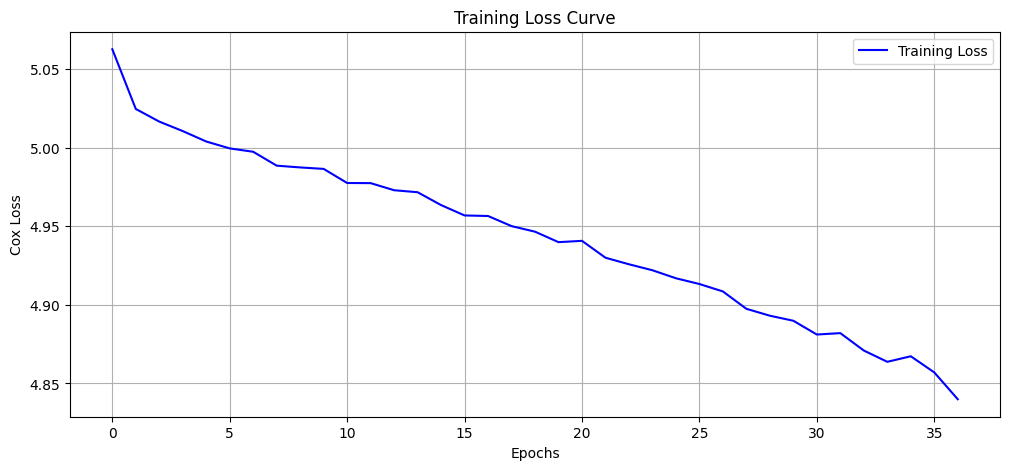


VISUALIZATION 1: TRAINING LOSS CURVE
• Shows the training loss over epochs.
• Helps monitor the convergence of the training process.
• A decreasing trend indicates the model is learning.
• Check for overfitting if the loss starts increasing after a certain point.



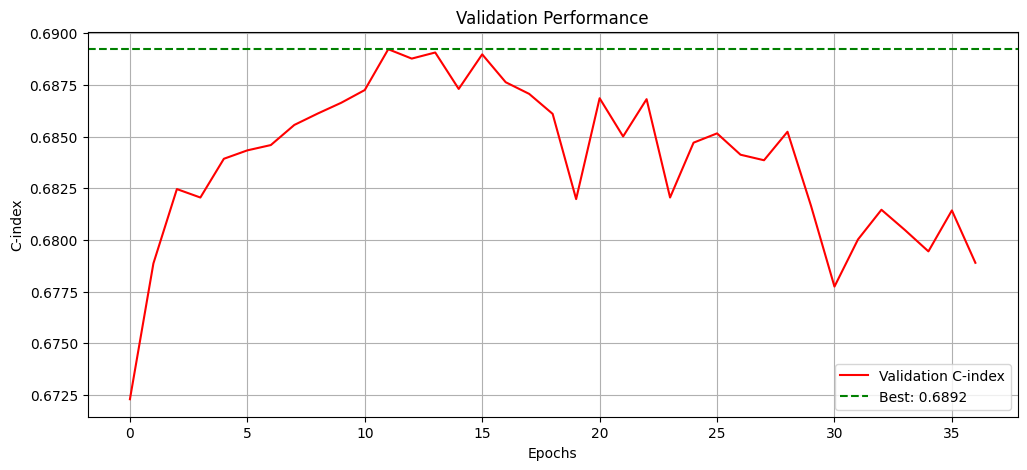


VISUALIZATION 2: VALIDATION PERFORMANCE
• Shows the validation C-index over epochs.
• Helps monitor the model's performance on the validation set.
• A higher C-index indicates better performance.
• The green dashed line indicates the best validation C-index achieved.



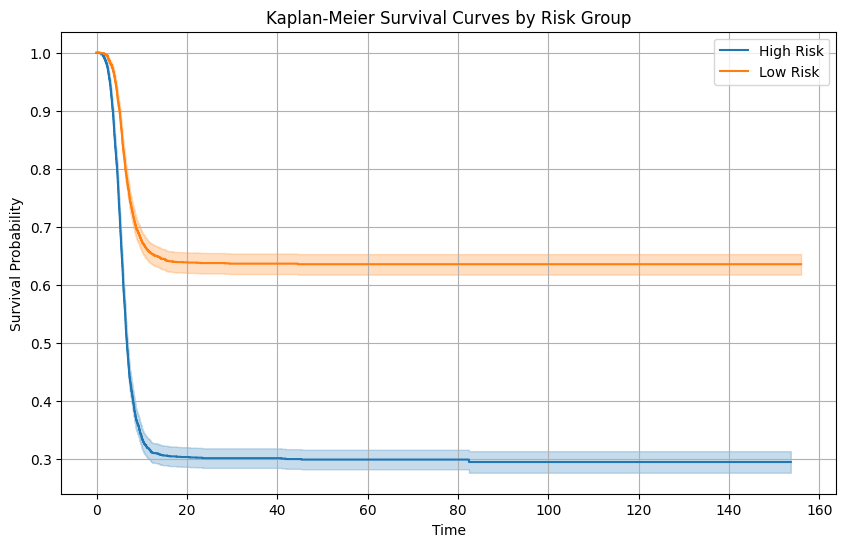


VISUALIZATION 3: KAPLAN-MEIER SURVIVAL CURVES BY RISK GROUP
• Shows the survival probability over time for high-risk and low-risk groups.
• Helps assess the model's ability to distinguish between different risk groups.
• A clear separation between the curves indicates good model performance.

+-------------------------+---------+
| Metric                  |   Value |
+=========================+=========+
| Best Validation C-index |  0.6892 |
+-------------------------+---------+
| Final Training Loss     |  4.8399 |
+-------------------------+---------+
| Epochs Trained          | 37      |
+-------------------------+---------+
| Improvement             |  0.0066 |
+-------------------------+---------+


In [ ]:
# Plot training loss curve
plt.figure(figsize=(12, 5))
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Cox Loss')
plt.grid(True)
plt.legend()
plt.show()

print("""
VISUALIZATION 1: TRAINING LOSS CURVE
• Shows the training loss over epochs.
• Helps monitor the convergence of the training process.
• A decreasing trend indicates the model is learning.
• Check for overfitting if the loss starts increasing after a certain point.
""")

# Plot validation performance
plt.figure(figsize=(12, 5))
plt.plot(val_scores, 'r-', label='Validation C-index')
plt.axhline(y=max(val_scores), color='g', linestyle='--',
            label=f'Best: {max(val_scores):.4f}')
plt.title('Validation Performance')
plt.xlabel('Epochs')
plt.ylabel('C-index')
plt.grid(True)
plt.legend()
plt.show()

print("""
VISUALIZATION 2: VALIDATION PERFORMANCE
• Shows the validation C-index over epochs.
• Helps monitor the model's performance on the validation set.
• A higher C-index indicates better performance.
• The green dashed line indicates the best validation C-index achieved.
""")

# Plot Kaplan-Meier survival curves
median_risk = np.median(val_preds)
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for name, mask in [('High Risk', val_preds > median_risk),
                   ('Low Risk', val_preds <= median_risk)]:
    kmf.fit(val_data["efs_time"][mask], val_data["efs"][mask], label=name)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Risk Group')
plt.ylabel('Survival Probability')
plt.xlabel('Time')
plt.grid(True)
plt.show()

print("""
VISUALIZATION 3: KAPLAN-MEIER SURVIVAL CURVES BY RISK GROUP
• Shows the survival probability over time for high-risk and low-risk groups.
• Helps assess the model's ability to distinguish between different risk groups.
• A clear separation between the curves indicates good model performance.
""")

# Print metrics table
best_epoch = np.argmax(val_scores) + 1
metrics = [
    ["Best Validation C-index", f"{max(val_scores):.4f}"],
    ["Final Training Loss", f"{train_losses[-1]:.4f}"],
    ["Epochs Trained", len(train_losses)],
    ["Improvement", f"{val_scores[-1] - val_scores[0]:.4f}"]
]
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))


# Load preprocessor,model and predict for the test dataset


Preprocessor loaded successfully.
Test data shape before preprocessing: (3, 57)
Categorical features preprocessed.
Numerical features preprocessed.
Test data shape after preprocessing: (3, 58)
Model loaded successfully.
Categorical features shape: torch.Size([3, 35])
Numerical features shape: torch.Size([3, 22])
Predictions shape: (3,)


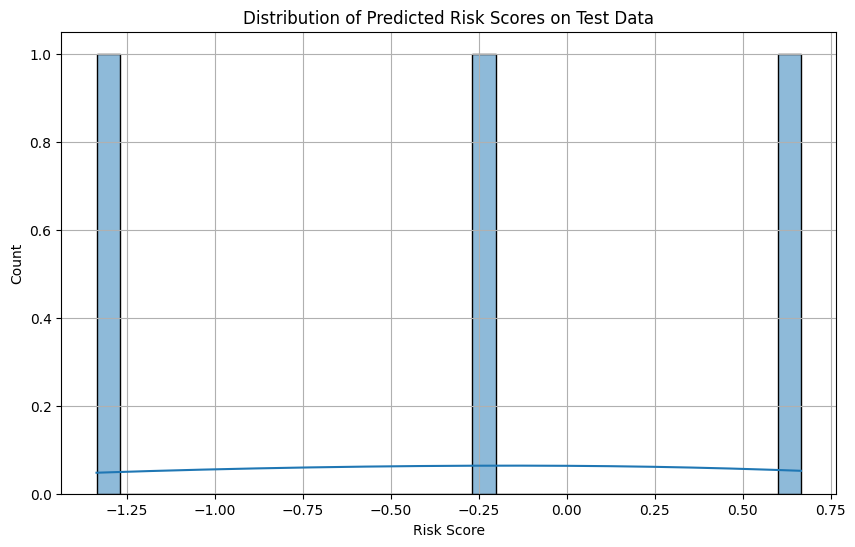


VISUALIZATION: DISTRIBUTION OF PREDICTED RISK SCORES
• Shows the distribution of predicted risk scores on the test data.
• Helps assess the range and spread of the predicted risk scores.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! Submission file saved as 'submission.csv'.


In [ ]:
# Load preprocessor
preprocessor = joblib.load("preprocessor.pkl")
cat_encoders = preprocessor['cat_encoders']
num_scaler = preprocessor['num_scaler']

print("Preprocessor loaded successfully.")

# Preprocess test data
test_df_processed = test_df.copy()
test_ids = test_df_processed['ID']
test_df_processed = test_df_processed.drop(columns=["ID"], errors='ignore')

print(f"Test data shape before preprocessing: {test_df_processed.shape}")

# Preprocess categorical features
for col, le in cat_encoders.items():
    if col in test_df_processed.columns:
        test_df_processed[col] = test_df_processed[col].fillna("MISSING")
        test_df_processed[col] = test_df_processed[col].map(lambda x: le.transform([x])[0]+1 if x in le.classes_ else 0)

print("Categorical features preprocessed.")

# Preprocess numerical features
numerical_cols = [col for col in num_scaler.feature_names_in_ if col in test_df_processed.columns]
if numerical_cols:
    test_df_processed[numerical_cols] = test_df_processed[numerical_cols].fillna(test_df_processed[numerical_cols].mean())
    test_df_processed[numerical_cols] = num_scaler.transform(test_df_processed[numerical_cols])

print("Numerical features preprocessed.")

test_df_processed = pd.concat([test_ids, test_df_processed], axis=1)

print(f"Test data shape after preprocessing: {test_df_processed.shape}")

# Load model and predict
model = FTTransformer(
    categories=[len(cat_encoders[col].classes_)+1 for col in categorical_cols],
    num_continuous=len(numerical_cols),
    dim=64,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.4,
    ff_dropout=0.4
).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

print("Model loaded successfully.")

with torch.no_grad():
    X_cat = torch.tensor(test_df_processed[categorical_cols].values, dtype=torch.long)
    X_num = torch.tensor(test_df_processed[numerical_cols].values, dtype=torch.float32)

    print(f"Categorical features shape: {X_cat.shape}")
    print(f"Numerical features shape: {X_num.shape}")

    preds = model(X_cat.to(device), X_num.to(device)).squeeze().cpu().numpy()

print(f"Predictions shape: {preds.shape}")

# Plot predictions
plt.figure(figsize=(10, 6))
sns.histplot(preds, kde=True, bins=30)
plt.title('Distribution of Predicted Risk Scores on Test Data')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print("""
VISUALIZATION: DISTRIBUTION OF PREDICTED RISK SCORES
• Shows the distribution of predicted risk scores on the test data.
• Helps assess the range and spread of the predicted risk scores.
""")

# Save submission
submission = pd.DataFrame({"ID": test_df["ID"], "prediction": preds})
submission.to_csv("submission.csv", index=False)
files.download("submission.csv")
print("✅ Done! Submission file saved as 'submission.csv'.")